<a href="https://colab.research.google.com/github/Minhvt34/Tokenization_TensorFlow/blob/main/TokenLeaner_TokenFuser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Import Section**

In [1]:
from tensorflow.keras.layers import MultiHeadAttention, Input, Dense, Reshape
from tensorflow.keras.layers import LayerNormalization, Layer
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D, Dropout

from tensorflow.keras.datasets import fashion_mnist
from tensorflow import reduce_mean, float32, range, reshape
from tensorflow.keras import utils
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.nn import gelu
from tensorflow.keras import Model, Sequential

import tensorflow as tf
from tensorflow.image import extract_patches

# For tokenization
#from tensorflow.image import extract_pathces

import numpy as np
import matplotlib.pyplot as plt

#for profiling
import time

In [ ]:
(train_X, train_Y), (test_X, test_Y) = fashion_mnist.load_data()
input_shape = train_X[0].shape

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
n_classes = 4
ind = np.where(train_Y < n_classes)[0]

train_X = np.array(list(map(train_X.__getitem__, ind)))
train_Y = np.array(list(map(train_Y.__getitem__, ind)))

print('\n training data shape: ', train_X.shape, 'training labels shape: ', train_Y.shape)

ind = np.where(test_Y < n_classes)[0]

test_X = np.array(list(map(test_X.__getitem__, ind)))
test_Y = np.array(list(map(test_Y.__getitem__, ind)))

print('\n test data shape: ', test_X.shape, 'test labels shape: ', test_Y.shape)

# convert labels to categorical labels
train_Y_categorical = utils.to_categorical(train_Y)
test_Y_categorical = utils.to_categorical(test_Y)



 training data shape:  (24000, 28, 28) training labels shape:  (24000,)

 test data shape:  (4000, 28, 28) test labels shape:  (4000,)


In [ ]:
test_Y

array([2, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [ ]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], train_X.shape[2], 1)).astype('float32')
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], test_X.shape[2], 1)).astype('float32')

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
import tensorflow
tensorflow.__version__

'2.10.0'

# **The Image Tokenizer Layer**

For image data, the key is to understand what a token represents. One possibility is to let each pixel represent a token. Howver, this would not scale well with large image datasets. In the ViT architecture, Dovovitskiy and his colleagues used equal-sized patches of images to act as tokens. This sequence of tokens is then input to a traditional transformer with a minimal change to its architecture.

In [2]:
class ImageTokenizerLayer(Layer):
  def __init__(self, token_shape):
    super(ImageTokenizerLayer, self).__init__()
    self.token_shape = token_shape

  def call(self, images):
    tokens = extract_patches(
        images = images,
        sizes = [1, self.token_shape[0], self.token_shape[1], 1],
        strides = [1, self.token_shape[0], self.token_shape[1], 1],
        rates = [1, 1, 1, 1],
        padding="VALID",
    )

    return tokens

In [34]:
with open("/content/drive/MyDrive/FEMTO_data/b1_3_hor_data_raw.npy", "rb") as f:
    b1_3_hor_data_raw = np.load(f, allow_pickle=True)

with open("/content/drive/MyDrive/FEMTO_data/b1_3_ver_data_raw.npy", "rb") as f:
    b1_3_ver_data_raw = np.load(f, allow_pickle=True)   

x_hor_test = b1_3_hor_data_raw.reshape(-1, 16, 16, 10).astype('float32')
x_ver_test = b1_3_ver_data_raw.reshape(-1, 16, 16, 10).astype('float32')

In [3]:
with open("/content/drive/MyDrive/FEMTO_data/b1_1_hor_data_raw.npy", "rb") as f:
    b1_1_hor_data_raw = np.load(f, allow_pickle=True)

with open("/content/drive/MyDrive/FEMTO_data/b1_1_ver_data_raw.npy", "rb") as f:
    b1_1_ver_data_raw = np.load(f, allow_pickle=True)

with open("/content/drive/MyDrive/FEMTO_data/b1_2_hor_data_raw.npy", "rb") as f:
    b1_2_hor_data_raw = np.load(f, allow_pickle=True)

with open("/content/drive/MyDrive/FEMTO_data/b1_2_ver_data_raw.npy", "rb") as f:
    b1_2_ver_data_raw = np.load(f, allow_pickle=True)

In [4]:
x_train = np.concatenate((b1_1_hor_data_raw.reshape(-1, 16, 16, 10).astype('float32'), 
                     b1_1_ver_data_raw.reshape(-1, 16, 16, 10).astype('float32'),
                     b1_2_hor_data_raw.reshape(-1, 16, 16, 10).astype('float32'),
                     b1_2_ver_data_raw.reshape(-1, 16, 16, 10).astype('float32')), axis=0)
x_train.shape

(7348, 16, 16, 10)

In [5]:
y = np.concatenate(([0]*2748, [1]*55, [0]*2748, [1]*55, [0]*826, [1]*45, [0]*826, [1]*45))
y_train = utils.to_categorical(np.asarray(y))
y_train.shape

(7348, 2)

In [ ]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
token_dims = np.round(np.sqrt(raw_data[0].shape)).astype("uint8")
train_tokens = ImageTokenizerLayer(token_dims)(raw_data)
train_tokens.shape

TensorShape([2803, 4, 4, 160])

In [ ]:
def display_tokens(img, tokenized_img):
  if (img.shape[-1] == 3):
    img = img[:, :, :]
  else:
    img = img[:,:,0]
  plt.imshow(img.astype("uint8"))
  plt.title('Train Image')

  fig, ax = plt.subplots(nrows=tokenized_img.shape[0],
  ncols=tokenized_img.shape[1],
  figsize=(4, 4),
  subplot_kw=dict(xticks=[], yticks=[]))
  for i in range(tokenized_img.shape[0]):
    for j in range(tokenized_img.shape[1]):# Check if it an RGB image
      if (tokenized_img.shape[-1] == 3):
        token = np.reshape(tokenized_img[i, j, :], (token_dims[0], token_dims[1], 3))
      else:# Show graysclae
        token = np.reshape(tokenized_img[i, j, :], (token_dims[0], token_dims[1]))
        ax[i,j].imshow(token)
        plt.gcf().suptitle('Image Tokens')

  fig, ax = plt.subplots(nrows=1,
  ncols=tokenized_img.shape[0]*tokenized_img.shape[1],
  figsize=(18, 2),
  subplot_kw=dict(xticks=[], yticks=[]))
  for i in range(tokenized_img.shape[0]):
    for j in range(tokenized_img.shape[1]):# Check if it an RGB image
      if (tokenized_img.shape[-1] == 3):
        token = np.reshape(tokenized_img[i, j, :], (token_dims[0], token_dims[1], 3))
      else:# Show graysclae
        token = np.reshape(tokenized_img[i, j, :], (token_dims[0], token_dims[1]))
        ax[i*tokenized_img.shape[1] + j].imshow(token)
        plt.gcf().suptitle('Sequence of image tokens')
  plt.show()


token_dims = np.round(np.sqrt(train_X[0].shape)).astype("uint8")
train_tokens = ImageTokenizerLayer(token_dims)(train_X)
test_tokens = ImageTokenizerLayer(token_dims)(test_X)

n_rows = train_tokens.shape[1]
n_cols = train_tokens.shape[2]

print("Train data shape", train_X.shape)
print("Train tokens shape", train_tokens.shape)

display_tokens(train_X[0], train_tokens[0])

# **Writing a Customized Embedding Layer for the ViT**

In a pure transformer architecture, all word tokens are encoded by summing their embeddings and their encoded positions. In the case of a ViT, the embedding layer projects an image linearly and sums it with its corresponding positional encoding. In this way, the positional encoding helps retain the order of a token in the sequence.

Below, you can see the implementation of a custom layer for encoding each image token. The call() method implements the following steps:

1. Normalize the input image tokens
2. Project the normalized image tokens by using a Dense layer (Projection)
3. Encode the positions using TensorFlow Embedding layer.
4. Add the projections and the encoded positions. Return their sum.

Here, the length of the resulting embedding is stored in the variable embed_dim, whose value cam be set by a user. Hence, the embedding layer produces an output of size total_tokens x embed_dim. Again, keep in mind that total_tokens = n_rows*ncols


In [6]:
class ImageEmbeddingLayer(Layer):
  def __init__(self, output_dim):
    super(ImageEmbeddingLayer, self).__init__()
    self.output_dim = output_dim

  # Need to define the Dense layer for linear projections # Embedding layer for positions
  def build(self, input_shape):
    self.total_img_tokens = input_shape[1]*input_shape[2]
    self.token_dims = input_shape[3]
    self.normalize_layer = LayerNormalization()
    self.dense = Dense(units=self.output_dim, input_shape=(None, self.token_dims))
    self.position_embedding = Embedding(input_dim=self.total_img_tokens, output_dim=self.output_dim)

  def call(self, input):
    img_tokens = reshape(input, [-1, self.total_img_tokens, self.token_dims])
    normalized_img_token = self.normalize_layer(img_tokens)
    img_projection = self.dense(normalized_img_token)
    all_positions = range(start=0, limit=self.total_img_tokens, delta=1)
    positions_encoding = self.position_embedding(all_positions)
    
    return positions_encoding + img_projection

In [7]:
class EncoderLayer(Layer):
  def __init__(self, total_heads, total_dense_units, embed_dim):
    super(EncoderLayer, self).__init__()# Multihead attention layer
    self.multihead = MultiHeadAttention(num_heads=total_heads, key_dim=embed_dim)# Feed forward network layer
    self.nnw = Sequential([Dense(total_dense_units, activation="relu"),Dense(embed_dim)])# Normalization
    self.normalize_layer = LayerNormalization()

  def call(self, inputs):
    attn_output = self.multihead(inputs, inputs)
    normalize_attn = self.normalize_layer(inputs + attn_output)
    nnw_output = self.nnw(normalize_attn)
    final_output = self.normalize_layer(normalize_attn + nnw_output)
    
    return final_output

# **Build the ViT**

It's time to construct the final ViT model from the ImageEmbeddingLayer and EncoderLayer. The final ouput of the transformer is produced by a softmax layer, where each unit of the layer corresponds to a category of the input image.

The code below constructs a ViT with four encoder layers followed by GlobalAveragePooling1D layer, an intermediate Dense layer, and the output Dense layer.

In [8]:
# Set the hyperparameters
EMBED_DIM = 256
NUM_HEADS = 3
TOTAL_DENSE = 100
EPOCHS = 6
FINAL_DENSE = 150
DROPOUT = 0.5

# Should return the model
def build_vit(input_shape, embed_dim=EMBED_DIM, num_heads=NUM_HEADS, total_dense_units=TOTAL_DENSE):# Start connecting layers
  inputs = Input(shape=input_shape)
  embedding_layer = ImageEmbeddingLayer(embed_dim)(inputs)
  encoder_layer1 = EncoderLayer(num_heads, total_dense_units, embed_dim)(embedding_layer)
  encoder_layer2 = EncoderLayer(num_heads, total_dense_units, embed_dim)(encoder_layer1)
  encoder_layer3 = EncoderLayer(num_heads, total_dense_units, embed_dim)(encoder_layer2)
  encoder_layer4 = EncoderLayer(num_heads, total_dense_units, embed_dim)(encoder_layer3)
  pooling_layer = GlobalAveragePooling1D()(encoder_layer4)
  dense_layer = Dense(FINAL_DENSE, activation='relu')(pooling_layer)
  dropout_layer = Dropout(DROPOUT)(dense_layer)
  
  outputs = Dense(2, activation="softmax")(dense_layer)# Construct the transformer model
 
  ViT = Model(inputs=inputs, outputs=outputs)
  ViT.compile(optimizer="adam", loss='categorical_crossentropy',
  metrics=['accuracy', 'Precision','Recall', TopKCategoricalAccuracy(5, name='top-5-accuracy')])
  
  return ViT

In [9]:
vit = build_vit(x_train[0].shape)

In [10]:
vit.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 10)]      0         
                                                                 
 image_embedding_layer (Imag  (None, 256, 256)         68372     
 eEmbeddingLayer)                                                
                                                                 
 encoder_layer (EncoderLayer  (None, 256, 256)         841060    
 )                                                               
                                                                 
 encoder_layer_1 (EncoderLay  (None, 256, 256)         841060    
 er)                                                             
                                                                 
 encoder_layer_2 (EncoderLay  (None, 256, 256)         841060    
 er)                                                         

In [11]:
idx = np.random.permutation(len(x_train))
x_train_shuffle, y_train_shuffle = x_train[idx], y_train[idx]

In [ ]:
from tensorflow import keras

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.00001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

In [12]:
EPOCHS = 10
start_time = time.time()
history = vit.fit(x_train_shuffle,
                  y_train_shuffle,
                  batch_size = 32,
                  epochs = EPOCHS,
                  validation_split = 0.3,
                  # callbacks=callbacks,
                  )
end_time = time.time()

print('\n ViT training time: ', end_time - start_time)

Epoch 1/10
161/161 [==============================] - 27s 133ms/step - loss: 0.1476 - accuracy: 0.9662 - precision: 0.9662 - recall: 0.9662 - top-5-accuracy: 1.0000 - val_loss: 0.1133 - val_accuracy: 0.9760 - val_precision: 0.9760 - val_recall: 0.9760 - val_top-5-accuracy: 1.0000
Epoch 2/10
161/161 [==============================] - 21s 133ms/step - loss: 0.1478 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - top-5-accuracy: 1.0000 - val_loss: 0.1386 - val_accuracy: 0.9760 - val_precision: 0.9760 - val_recall: 0.9760 - val_top-5-accuracy: 1.0000
Epoch 3/10
161/161 [==============================] - 23s 140ms/step - loss: 0.1359 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - top-5-accuracy: 1.0000 - val_loss: 0.1142 - val_accuracy: 0.9760 - val_precision: 0.9760 - val_recall: 0.9760 - val_top-5-accuracy: 1.0000
Epoch 4/10
161/161 [==============================] - 22s 137ms/step - loss: 0.1383 - accuracy: 0.9714 - precision: 0.9714 - recall: 0.9714 - top-5-accuracy:

In [13]:
n_metrics = int(len(history.history.keys())/2)
metrics = list(history.history.values())
metric_names = list(history.history.keys())

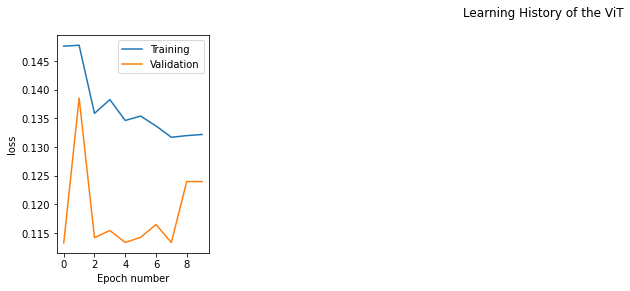

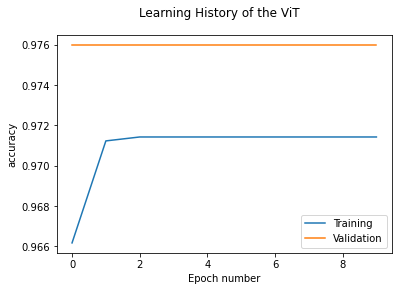

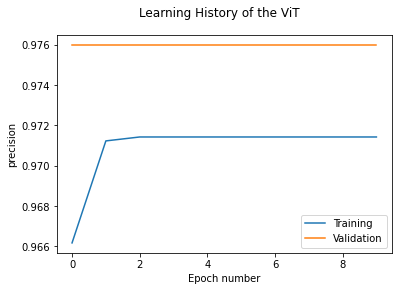

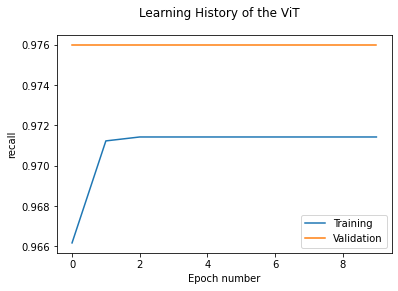

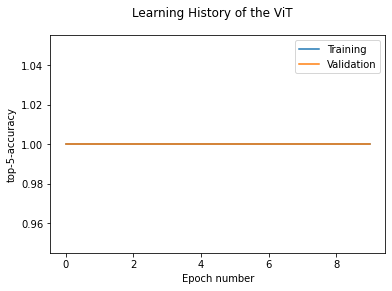

In [14]:
fig = plt.figure(figsize=(18, 4))

for i in np.arange(n_metrics):
  fig.add_subplot(101 + n_metrics*10 + i)
  plt.plot(metrics[i])
  plt.plot(metrics[i + n_metrics])
  plt.legend(['Training', 'Validation'])
  plt.xlabel('Epoch number')
  plt.ylabel(metric_names[i])

  plt.gcf().suptitle('Learning History of the ViT')

  plt.subplots_adjust(wspace=0.4)
  plt.show()


In [15]:
train_metrics = vit.evaluate(x_train_shuffle, y_train_shuffle)
#test_metrics = vit.evaluate(test_tokens, test_Y_categorical)

230/230 [==============================] - 11s 46ms/step - loss: 0.1331 - accuracy: 0.9728 - precision: 0.9728 - recall: 0.9728 - top-5-accuracy: 1.0000


In [16]:
print('\nTraining set evaluation of ViT')

for i, value in enumerate(train_metrics):
  print(metric_names[i], ': ', value)
  print('\nTest set evaluation of ViT')
  
# for i, value in enumerate(test_metrics):
#   print(metric_names[i], ': ', value)


Training set evaluation of ViT
loss :  0.1331355720758438

Test set evaluation of ViT
accuracy :  0.9727817177772522

Test set evaluation of ViT
precision :  0.9727817177772522

Test set evaluation of ViT
recall :  0.9727817177772522

Test set evaluation of ViT
top-5-accuracy :  1.0

Test set evaluation of ViT


In [35]:
x_hor_1_3_pred = vit.predict(x_hor_test)

75/75 [==============================] - 4s 44ms/step


In [50]:
x_hor_1_3_pred[2370]

array([0.94659996, 0.05340008], dtype=float32)

In [48]:
classes = []
for pred in x_hor_1_3_pred:
  idx = tf.math.argmax(pred)
  if idx.numpy() == 1:
    print(f"failure occurs: {idx.numpy()}")
  classes.append(idx.numpy())
#classes

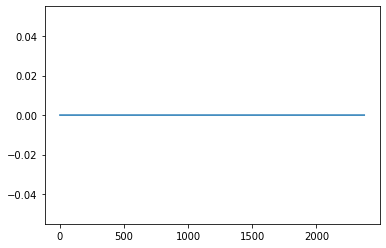

In [47]:
plt.plot(classes)

# **How To Make the ViT Faster**

While there are several methods for making the ViT faster, we will implement the TokenLearner of Ryoo and colleagues.
The TokenLearner layer learns to identify important tokens in the input data. It then dynamically selects these tokens conditioned on the input, reducing the number of tokens used for classifying images. This algorithm mimics the elementwise spatial self-attention

# **What is the Basic TokenLearner Algorithm?**

Here is the basic algorithm for the layer that implements the TokenLearner. In the algorithm below, n_maps represents the number of fature maps and is a user-supplied parameter.

1. Compute weight maps conditioned on the inputs. The number of weight maps are n_maps. They effectively represent the attention weights. The weights have dimensions n_rows x n_cols x n_maps.
2. Reshape the weights to total_tokens x n_maps.
3. Multiply the weight maps by the inputs to get weighted inputs. The input size is total_tokens x embed_dim and the resulting weighted input size is total_tokens x n_maps x embed_dim.
4. Apply spatial global everage pooling to reduce the dimensions of the weighted inputs to n_maps x embed_dim.

How Is the Weight Map Computed?

the authors compute the weight map of the TokenLearner as follows:

1. Reshape the inputs to n_rows x n_cols x embed_dim.
2. Pass the inputs through a series of convolution layers with a Gaussian Error Linear Unit (GELU) activation function. 
3. Pass the convolved output through a convolution layer with sigmoid activation function. The dimensions of the result are n_rows x n_cols x n_maps.

# **Where Is the Token Learner in the Transformer Network?**

the Authors suggest you place the TokenLearner layer anywhere between the transformer encoder layers. They experimented with placing this layer at different points in the network. They observed that inserting the TokenLearner after the initial one quarter of the network reduces the computations to less than a third of the baseline with no compromise in accuracy. Moreover, if this layer is inserted further down in the network, the resulting model has improved accuracy


In [25]:
n_rows = x_train_shuffle.shape[1]
n_cols = x_train_shuffle.shape[2]

In [17]:
class TokenLearningLayer(Layer):
  def __init__(self, n_maps, token_dims):
    super(TokenLearningLayer, self).__init__()
    self.n_maps = n_maps
    self.token_dims = token_dims

  def build(self, input_shape):
    self.input_embed_dim = input_shape[-1]
    self.model = Sequential()# Add Reshape layer to make a nrow x ncol x embed_dim shape
    self.model.add(Reshape((self.token_dims[0], self.token_dims[1], self.input_embed_dim)))# Connect 4 Conv2D layers
    
    for i in range(4):
        conv2D_layer = Conv2D(filters=self.n_maps, kernel_size=(3, 3), activation=gelu, padding="same", use_bias=False)

        self.model.add(conv2D_layer)# Connect with the last conv2D with sigmoid filter

    conv2D_sigmoid_layer = Conv2D(filters=self.n_maps, kernel_size=(3, 3), activation="sigmoid", padding="same", use_bias=False)
    
    self.model.add(conv2D_sigmoid_layer)# Reshape to (batch, nrow*ncol, n_maps)
    self.model.add(Reshape((-1, self.n_maps)))
  
  def call(self, inputs):
    total_tokens = inputs.shape[1] # attn_wts shape: (batch, row*col, n_maps)
    attn_wts = self.model(inputs) # Reshape inputs and attn_wts to match dimensions for multiplication
    inputs = Reshape((total_tokens, 1, self.input_embed_dim))(inputs)
    attn_wts = Reshape((total_tokens, self.n_maps, 1))(attn_wts) # attended_output has shape (batch, row*col, n_maps, embed_dim)
    attended_output = inputs*attn_wts
    # Pool the result, will reduce one dimension
    output = reduce_mean(attended_output, axis=1)
    
    return output

In [27]:
n_classes = 2

In [ ]:
class TokenFuserLayer(Layer):
  def __init__(self, n_maps, token_dims):
    super(TokenFuserLayer, self).__init__()
    self.n_maps = n_maps
    self.token_dims = token_dims
    
  
  def build(self, input_shape):
    self.input_embed_dim = input_shape[-1]
    self.model = Sequential()# Add Reshape layer to make a nrow x ncol x embed_dim shape
    self.model.add(Reshape((self.token_dims[0], self.token_dims[1], self.input_embed_dim)))# Connect 4 Conv2D layers
    
    for i in range(4):
        conv2D_layer = Conv2D(filters=self.n_maps, kernel_size=(3, 3), activation=gelu, padding="same", use_bias=False)

        self.model.add(conv2D_layer)# Connect with the last conv2D with sigmoid filter

    conv2D_sigmoid_layer = Conv2D(filters=self.n_maps, kernel_size=(3, 3), activation="sigmoid", padding="same", use_bias=False)
    
    self.model.add(conv2D_sigmoid_layer)# Reshape to (batch, nrow*ncol, n_maps)
    self.model.add(Reshape((-1, self.n_maps)))

    self.transform_model = Sequential()
    self.transform_model.add(Reshape((EMBED_DIM, NMAPS)))
    self.transform_model.add(Dense(NMAPS, activation = None))
    self.transform_model.add(Reshape((NMAPS, EMBED_DIM)))

    self.bw_transform = Sequential()
    self.bw_transform.add(Dense(NMAPS, activation = "sigmoid"))
    self.bw_transform.add(Reshape((int(n_rows*n_cols), NMAPS)))

  def call(self, inputs, original):

    B, S, C = inputs.shape
    B, hw, C = original.shape
    H = np.sqrt(hw)
    W = hw // H

    
    inputs_transform = self.transform_model(inputs)
    

    Bw = self.bw_transform(original)
    BwY = tf.matmul(Bw, inputs_transform)


    attn_wts = self.model(original)

    #output = tf.reshape(BwY + attn_wts, (int(H), int(W), C))
    
    return BwY + attn_wts

In [18]:
NMAPS=4

In [ ]:
class EmbeddingLayer(Layer):
  def __init__(self, token_dims, embed_dim):
    super(EmbeddingLayer, self).__init__()
    
    self.token_dims = token_dims
    self.embed_dim = embed_dim

  # Need to define the Dense layer for linear projections # Embedding layer for positions
  def build(self, input_shape):
    print(f"Input shape: {input_shape}")
    self.bw_transform = Sequential()
    self.bw_transform.add(Reshape((-1, self.token_dims[0]*self.token_dims[1], self.embed_dim)))

  def call(self, input):
    img_projection = self.bw_transform(input)
    
    return img_projection

In [19]:
# Set the hyperparameters
EMBED_DIM = 128
NUM_HEADS = 3
TOTAL_DENSE = 100
EPOCHS = 6
FINAL_DENSE = 150
DROPOUT = 0.5

In [23]:
def build_fast_vit(input_shape, embed_dim=EMBED_DIM, num_heads=NUM_HEADS, total_dense_units=TOTAL_DENSE, n_maps=NMAPS):# Start connecting layers
    
    inputs = Input(shape=x_train_shuffle[0].shape)#tokenizer_layer = ImageTokenizerLayer(token_dims)(inputs)
    embedding_layer = ImageEmbeddingLayer(embed_dim)(inputs)
    encoder_layer1 = EncoderLayer(num_heads, total_dense_units, embed_dim)(embedding_layer)
    encoder_layer2 = EncoderLayer(num_heads, total_dense_units, embed_dim)(encoder_layer1)

    print(f"encoder layer output: {encoder_layer2.shape}")

    token_learning_layer = TokenLearningLayer(n_maps, (n_rows, n_cols))(encoder_layer2)

    encoder_layer3 = EncoderLayer(num_heads, total_dense_units, embed_dim)(token_learning_layer)
    encoder_layer4 = EncoderLayer(num_heads, total_dense_units, embed_dim)(encoder_layer3)

    #token_fuser_layer = TokenFuserLayer(EMBED_DIM, (n_rows, n_cols))(encoder_layer3, encoder_layer2)
    #embedding_layer = EmbeddingLayer((n_rows, n_cols), embed_dim)(token_fuser_layer)

    pooling_layer = GlobalAveragePooling1D()(encoder_layer4)
    dense_layer = Dense(150, activation='relu')(pooling_layer)
    dropout_layer = Dropout(.5)(dense_layer)

    outputs = Dense(n_classes, activation="softmax")(dense_layer)# Construct the transformer model
    fast_vit = Model(inputs=inputs, outputs=outputs)

    fast_vit.compile(optimizer="adam", loss="categorical_crossentropy",
    metrics=['accuracy', 'Precision', 'Recall',
    TopKCategoricalAccuracy(5, name="top-5-accuracy")])

    return fast_vit

In [28]:
fast_vit = build_fast_vit(x_train_shuffle[0].shape)

encoder layer output: (None, 256, 128)


In [29]:
fast_vit.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 16, 16, 10)]      0         
                                                                 
 image_embedding_layer_3 (Im  (None, 256, 128)         34196     
 ageEmbeddingLayer)                                              
                                                                 
 encoder_layer_10 (EncoderLa  (None, 256, 128)         223972    
 yer)                                                            
                                                                 
 encoder_layer_11 (EncoderLa  (None, 256, 128)         223972    
 yer)                                                            
                                                                 
 token_learning_layer_1 (Tok  (None, 4, 128)           5184      
 enLearningLayer)                                          

In [31]:
start_time = time.time()
history_fast = fast_vit.fit(x_train_shuffle, y_train_shuffle,
batch_size=32, epochs=EPOCHS, validation_split=0.33)
end_time = time.time()
print('\nTime to train fast_vit', end_time-start_time)

Epoch 1/6
154/154 [==============================] - 16s 53ms/step - loss: 0.1433 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - top-5-accuracy: 1.0000 - val_loss: 0.1194 - val_accuracy: 0.9773 - val_precision: 0.9773 - val_recall: 0.9773 - val_top-5-accuracy: 1.0000
Epoch 2/6
154/154 [==============================] - 7s 47ms/step - loss: 0.1403 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - top-5-accuracy: 1.0000 - val_loss: 0.1111 - val_accuracy: 0.9773 - val_precision: 0.9773 - val_recall: 0.9773 - val_top-5-accuracy: 1.0000
Epoch 3/6
154/154 [==============================] - 8s 52ms/step - loss: 0.1370 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - top-5-accuracy: 1.0000 - val_loss: 0.1101 - val_accuracy: 0.9773 - val_precision: 0.9773 - val_recall: 0.9773 - val_top-5-accuracy: 1.0000
Epoch 4/6
154/154 [==============================] - 7s 47ms/step - loss: 0.1383 - accuracy: 0.9705 - precision: 0.9705 - recall: 0.9705 - top-5-accuracy: 1.0000 - v

In [32]:
n_metrics = int(len(history_fast.history.keys())/2)
metrics = list(history_fast.history.values())
metric_names = list(history_fast.history.keys())

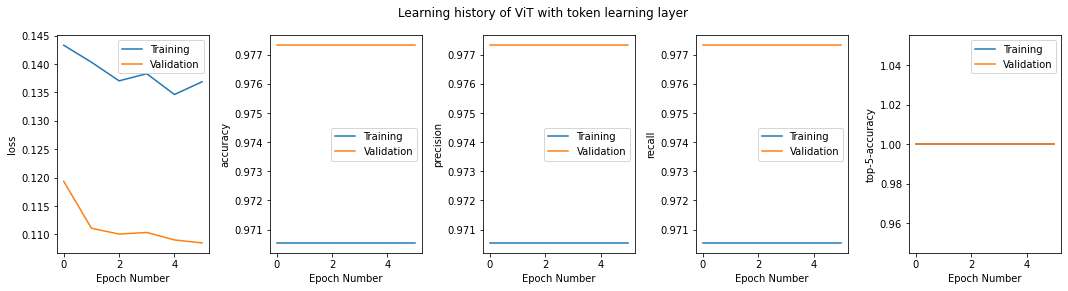

In [33]:
metrics_fast = list(history_fast.history.values())
fig = plt.figure(figsize=(18,4))

for i in np.arange(n_metrics):
  fig.add_subplot(101 + n_metrics*10 +i)
  plt.plot(metrics_fast[i])
  plt.plot(metrics_fast[i+n_metrics])
  plt.legend(['Training', 'Validation'])
  plt.xlabel('Epoch Number')
  plt.ylabel(metric_names[i])

  plt.gcf().suptitle('Learning history of ViT with token learning layer')
  plt.subplots_adjust(wspace=0.4)
plt.show()

In [ ]:
!pip install tokenlearner-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
from tokenlearner_pytorch import TokenLearner, TokenFuser

In [ ]:
mhsa = nn.MultiheadAttention(3, 1)
tklr = TokenLearner(S=8)
tkfr = TokenFuser(H=32, W=32, C = 3, S=8)

In [ ]:
x = torch.rand(512, 8, 3)

In [ ]:
projection = nn.Linear(8, 8, bias = False)

In [ ]:
y = projection(x.rehape(-1, 3, 8))
y.shape

In [ ]:
y = y.view(8, 512, 3)
y.shape

torch.Size([8, 512, 3])

In [ ]:
y, _ = mhsa(y, y, y)
y.shape

torch.Size([8, 512, 3])